<p><a href="https://www.asu.edu.eg/"><img align="right" src="https://ums.asu.edu.eg/images/logo.png" width="100" /></a></p>
<div align=left>
<h1>
  Spam Detection
</h1>
    <h6>
        Data Analytics Task
    </h6>
</div>
<br>
<br>

#### All libraries that we will need and use through the notebook

In [337]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import joblib
import pickle
%matplotlib inline

#### Reading the dataset

In [338]:
df = pd.read_csv('data_spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Cleaning

In [339]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)

In [340]:
df = df.rename({"v1":"Category", "v2":"Message"}, axis=1)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [341]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Text(0.5, 1.0, 'Number of ham and spam messages')

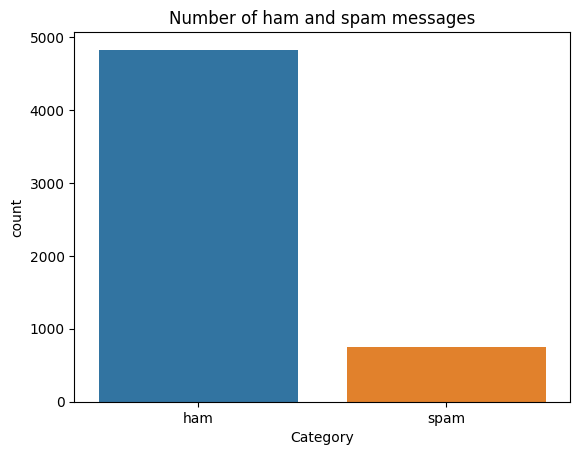

In [343]:
#plot the ham and spam messages to understand the distribution
sns.countplot(data=df, x=df.Category)
plt.xlabel('Category')
plt.title('Number of ham and spam messages')

<AxesSubplot: title={'center': 'Category'}>

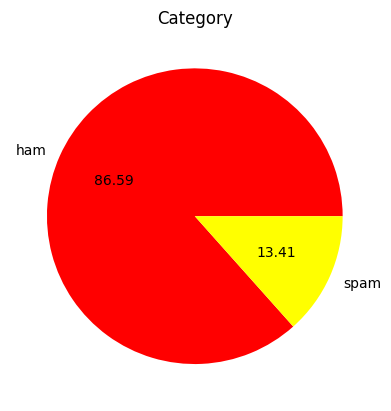

In [344]:
df.groupby('Category').size().plot(kind='pie', autopct='%.2f', colors=['red', 'yellow'], title="Category")

We can observe that Ham contains 86.6% while spam constitute only 13.4% of the total dataset

# Text Preprocessing

### Removing punctuations from Message Column

- `remove_punctuations()` which takes a string as input and returns the same string with all punctuation characters removed. The function first creates a translation table using `str.maketrans()` and the `string.punctuation` constant, which contains all the punctuation characters. It then uses the `translate()` method of the string to remove the punctuations.
- I use the `apply()` method to apply the `remove_punctuations()` function to each row of the `Meassage` column and replace the original values with the modified ones.

In [345]:
# Define a function to remove punctuations from a string
def remove_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# Apply the remove_punctuations function to each row of the column
df['Message'] = df['Message'].apply(remove_punctuations)

In [346]:
df.head()

,Category,Message
0,ham,Go until jurong point crazy Available only in ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor U c already then say
4,ham,Nah I dont think he goes to usf he lives aroun...


### Converting all letters to lower case

- I use the `apply()` method to apply a lambda function to each row of the `Message` column. The lambda function uses the `lower()` method to convert all letters in the string to lower case.

In [347]:
# Convert all letters in the column to lower case
df['Message'] = df['Message'].apply(lambda x: x.lower())
df.head()

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


### Removing stop words

- After importing the `stopwords` and `word_tokenize` modules from the `nltk` library
- We first define the stop words to remove as the set of English stop words using `stopwords.words('english')`.
- Second, we difine the `remove_stop_words()` function to remove the stop words from a string. The function uses the `word_tokenize()` method to tokenize the string into words, and then filters out the stop words using a list comprehension. Finally, the function joins the remaining words into a single string.
- Then we apply the `remove_stop_words()` function to each row of the `Message` column using the `apply()` method, and replaces the original values with the modified ones.

In [348]:
# Define the stop words to remove
stop_words = set(stopwords.words('english'))

# Define a function to remove stop words from a string
def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

# Apply the remove_stop_words function to each row of the column
df['Message'] = df['Message'].apply(remove_stop_words)

In [349]:
df.head()

,Category,Message
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though


### Tokenization, Stemming and Lemmatization

- We first creates a `WordNetLemmatizer` object and a `PorterStemmer` object, which will be used to perform lemmatization and stemming on the words, respectively
- Then we define a function called `preprocess_text()` that takes a string as input, tokenizes it into words using `word_tokenize()`, applies the `lemmatize()` method of the `WordNetLemmatizer` object to each word, and then applies the `stem()` method of the `PorterStemmer` object to each lemmatized word. The resulting list of stemmed words is then joined back into a single string using `join()`.

In [350]:
# Create a lemmatizer and stemmer object
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Define a function to tokenize, lemmatize, and stem a string
def preprocess_text(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Stem each word
    stemmed_words = [stemmer.stem(word) for word in lemmatized_words]
    
    # Join the stemmed words back into a single string
    processed_text = ' '.join(stemmed_words)
    
    return processed_text

# Apply the preprocess_text function to each row of the column
df['Message'] = df['Message'].apply(preprocess_text)

In [351]:
df.head()

,Category,Message
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think go usf life around though


## Bag of words & word embedding Features

1. First, we create an instance of the CountVectorizer class with a maximum of 5000 features. <br>The `CountVectorizer` class is used to convert the text data into a matrix of token counts. The `max_features` parameter specifies the maximum number of features to keep.

2. Fitting and transform the "Message" column using the CountVectorizer object. <br>The `fit_transform` method of the `CountVectorizer` object is used to fit the vectorizer to the "Message" column of the data frame `df` and transform the data into a matrix of token counts. The resulting matrix `bow_features` will have one row for each message in the data frame and one column for each token in the vocabulary.

3. Creating an instance of the Word2Vec model with a vector size of 100 and minimum word count of 1. <br>The `Word2Vec` class is used to create a word embedding model that can represent words as dense vectors. The `vector_size` parameter specifies the size of the word vectors, and the `min_count` parameter specifies the minimum number of times a word must appear in the data to be included in the vocabulary.

4. We define a function `get_mean_word_embedding` to calculate the average word embedding for each row. <br>The `get_mean_word_embedding` function takes a single argument `row`, which is a string containing a message. The function splits the message into individual words, looks up the word embeddings for each word in the `w2v_model`, and calculates the average embedding for the entire message. If a word is not found in the vocabulary, it is ignored. If no embeddings are found for the message, the function returns a vector of zeros with the same size as the word vectors.

5. We apply the `get_mean_word_embedding` function to each row of the "Message" column. <br>The `apply` method of the `DataFrame` object is used to apply the `get_mean_word_embedding` function to each row of the "Message" column in the data frame `df`. The resulting `w2v_features` object will contain one row for each message in the data frame and one column for each element in the word vectors.

6. Now, We concatenate the bag-of-words and word embedding feature matrices together. <br>The `numpy.concatenate` function is used to concatenate the bag-of-words feature matrix `bow_features` with the word embedding feature matrix `w2v_features`. The resulting `features` matrix will have one row for each message in the data frame and a number of columns

In [352]:
# create an instance of the CountVectorizer class
cv = CountVectorizer()

# fit and transform the "Message" column using the CountVectorizer
bow_features = cv.fit_transform(df['Message'])

# create an instance of the Word2Vec model
w2v_model = Word2Vec(sentences=df['Message'].apply(lambda x: x.split()), vector_size=100, min_count=1)

# save the trained Word2Vec model to disk using pickle
with open('word2vec.pkl', 'wb') as f:
    pickle.dump(w2v_model, f)

# define a function to calculate the average word embedding for each row
def get_mean_word_embedding(row):
    words = row.split()
    embeddings = []
    for word in words:
        if word in w2v_model.wv:
            embeddings.append(w2v_model.wv[word])
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros((100,))

# apply the get_mean_word_embedding function to each row of the "Message" column
w2v_features = df['Message'].apply(get_mean_word_embedding)

# concatenate the bag-of-words and word embedding feature matrices together
features = np.concatenate((bow_features.toarray(), np.stack(w2v_features.values)), axis=1)

In [353]:
# store the vectorizer object in a separate pickle file
pickle.dump(cv, open('count_vectorizer.pkl', 'wb'))

# Creating a model that fits the data

In [354]:
# Label Encode The Target Variable
encode = LabelEncoder()
df.Category = encode.fit_transform(df.Category)

In [355]:
df.head()

,Category,Message
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri 2 wkli comp win fa cup final tkt 21...
3,0,u dun say earli hor u c alreadi say
4,0,nah dont think go usf life around though


In [356]:
x_train, x_test, y_train, y_test = train_test_split(features, df["Category"], test_size = 0.2, random_state = 0)

### Logistic Regression Model

In [357]:
LR = LogisticRegression()
LR.fit(x_train,y_train)
predict = LR.predict(x_test)
print(classification_report(y_test, predict))
LRAcc = accuracy_score(predict,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LRAcc*100))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       949
           1       0.99      0.84      0.91       166

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.97      1115

Logistic Regression accuracy is: 97.58%


## Load the Logestic Regresssion Model

In [358]:
joblib_file = "spam_detection_model_LR"
joblib.dump(LR, joblib_file)
loaded_model = joblib.load(open(joblib_file, 'rb'))
pred_y = loaded_model.predict(x_test)
result = np.round(accuracy_score(y_test, pred_y), 2)
print(result)

0.98
